In [24]:
legend_utils_path = '/global/homes/f/fnafis/LEGEND/legend'
import sys
if legend_utils_path not in sys.path:
    sys.path.append(legend_utils_path)
import uproot as ur
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import pygama.math.histogram as pgh
import legend_utils as lu
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FormatStrFormatter
plt.style.use('~/KrSTC/data/physrev.mpl')

def get_peak_and_bkg_count(h, b):
    b_mids = (b[1:] + b[:-1])/2
    fit_params = lu.fit_peak_binned_extra_basic(b_mids, h)
    peak_count = fit_params['area']
    return peak_count, np.sum(h) - peak_count, (np.sum(h) - peak_count)/(b[-1]-b[0])


In [25]:
dep_peaks = {
    '1987':
    {
        'energy':1987.0,
        'sidebands':[[1975,1983],[1991,2000]],
        'peak_range': [1983,1991]
    }
}
fep_peaks = {
    '3009':
    {
        'energy':3009.0,
        'sidebands':[[2995,3000],[3020,3025]],
        'peak_range': [3005,3015]
    }
}
sep_peaks = {
    '2498':
    {
        'energy':2498.0,
        'sidebands':[[2485,2490],[2510,2515]],
        'peak_range': [2495,2505]
    }
}

dets_to_use = [1010704]

### Sim from vancouver results

In [26]:
evt_filenames_vancouver = '/global/homes/f/fnafis/LEGEND/legend/sims/evt_filenames_vancouver.txt'
df_vanc = pd.DataFrame()
primaries_vanc = 0
with open(evt_filenames_vancouver) as f:
    evt_filenames = f.read().splitlines()
    for evt_filename in evt_filenames:
        ff = ur.open(evt_filename)
        # print(evt_filename, 'opened')
        dets = ff['simTree/mage_id'].array(library='np')
        primaries_vanc += len(dets)
        dets = np.concatenate(dets)
        
        energies = ff['simTree/energy'].array(library='np')
        energies = np.concatenate(energies)
        d = pd.DataFrame({'mage_id': dets, 'energy': energies})
        df_vanc = pd.concat([df_vanc, d], ignore_index=True)
   
print('primaries_vanc', primaries_vanc)
df_vanc['energy'] = df_vanc['energy'].apply(lambda x: x*1000)
df_vanc

primaries_vanc 119994453


,mage_id,energy
0,1010704,144.095972
1,1011102,700.127400
2,1010906,401.827494
3,1010805,434.088314
4,1010806,603.299438
...,...,...
153941950,1011004,162.523602
153941951,1010705,305.416521
153941952,1011102,183.354690
153941953,1010703,3.997480


In [99]:
evt_filenames = '/global/homes/f/fnafis/LEGEND/legend/sims/evt_filenames_sis2_24mm_100Kx20.txt'
df = pd.DataFrame()
primaries = 0
with open(evt_filenames) as f:
    evt_filenames = f.read().splitlines()
    for evt_filename in evt_filenames:
        # print(evt_filename)
        ff = ur.open(evt_filename)
        # print(evt_filename, 'opened')
        dets = ff['simTree/mage_id'].array(library='np')
        primaries += len(dets)
        dets = np.concatenate(dets)
        
        energies = ff['simTree/energy'].array(library='np')
        energies = np.concatenate(energies)
        d = pd.DataFrame({'mage_id': dets, 'energy': energies})
        df = pd.concat([df, d], ignore_index=True)
   
print(primaries)
df['energy'] = df['energy'].apply(lambda x: x*1000)
df

1999775


,mage_id,energy
0,1010907,1730.420247
1,1011003,1917.793225
2,1011004,1.506126
3,1010704,3009.165758
4,1011109,218.103288
...,...,...
1054791,1010805,79.794798
1054792,1010505,2467.371269
1054793,1010704,281.012526
1054794,1010703,336.118369


gamma_scaled_primaries 1440.2834136441384 M


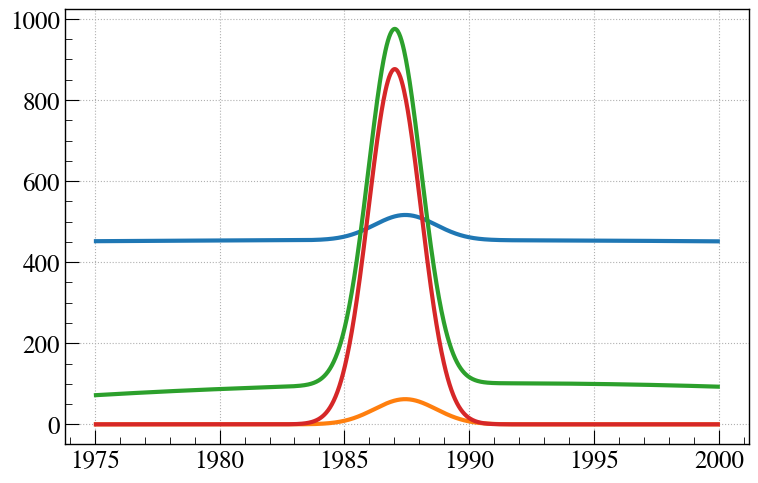

In [70]:
def get_scaled_Co_primaries(full_Co_primaries, full_Co_energies, gamma_energies, peak, axis=None):
    h,b,v = pgh.get_hist(full_Co_energies, range=(peak['sidebands'][0][0], peak['sidebands'][1][1]), dx=0.1)
    b_mids = (b[1:] + b[:-1])/2
    # plt.figure()
    fit_params = lu.fit_peak_binned_extra_basic(b_mids, h, axis=axis)
    full_Co_peak_count = fit_params['area']

    h,b,v = pgh.get_hist(gamma_energies, range=(peak['sidebands'][0][0], peak['sidebands'][1][1]), dx=0.1)
    b_mids = (b[1:] + b[:-1])/2
    # plt.figure()
    fit_params = lu.fit_peak_binned_extra_basic(b_mids, h, axis=axis)
    gamma_peak_count = fit_params['area']

    return full_Co_primaries * gamma_peak_count/full_Co_peak_count


scaled_Co_primaries = get_scaled_Co_primaries(primaries_vanc, df_vanc['energy'], df['energy'], dep_peaks['1987'], axis=plt.gca())
print('gamma_scaled_primaries', scaled_Co_primaries/1e6, 'M')


In [43]:
def get_bkg_per_keV_per_primary(full_Co_df, full_Co_primaries, geds, peak):
    d = full_Co_df[full_Co_df['mage_id'].isin(geds)]
    h,b,v = pgh.get_hist(d['energy'], range=(peak['sidebands'][0][0], peak['sidebands'][1][1]), dx=0.1)
    b_mids = (b[1:] + b[:-1])/2
    fit_params = lu.fit_peak_binned_extra_basic(b_mids, h)
    peak_count = fit_params['area']
    return (np.sum(h) - peak_count)/(b[-1]-b[0])/full_Co_primaries
bkg_per_keV_per_primary_full_Co = get_bkg_per_keV_per_primary(df_vanc, primaries_vanc, dets_to_use, dep_peaks['1987'])
print('bkg_per_keV_per_primary_full_Co', bkg_per_keV_per_primary_full_Co)

bkg_per_keV_per_primary_full_Co 1.8933232244430938e-05


bkg_per_keV_per_primary_full_Co 1.8933232244430938e-05


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


bkg_per_keV_per_primary_full_Co 5.011644827456197e-08


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


bkg_per_keV_per_primary_full_Co 9.202359812710166e-06


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


bkg_per_keV_per_primary_full_Co 2.8928226403597354e-08


Text(0.5, 1.0, '3009 in [1010809]')

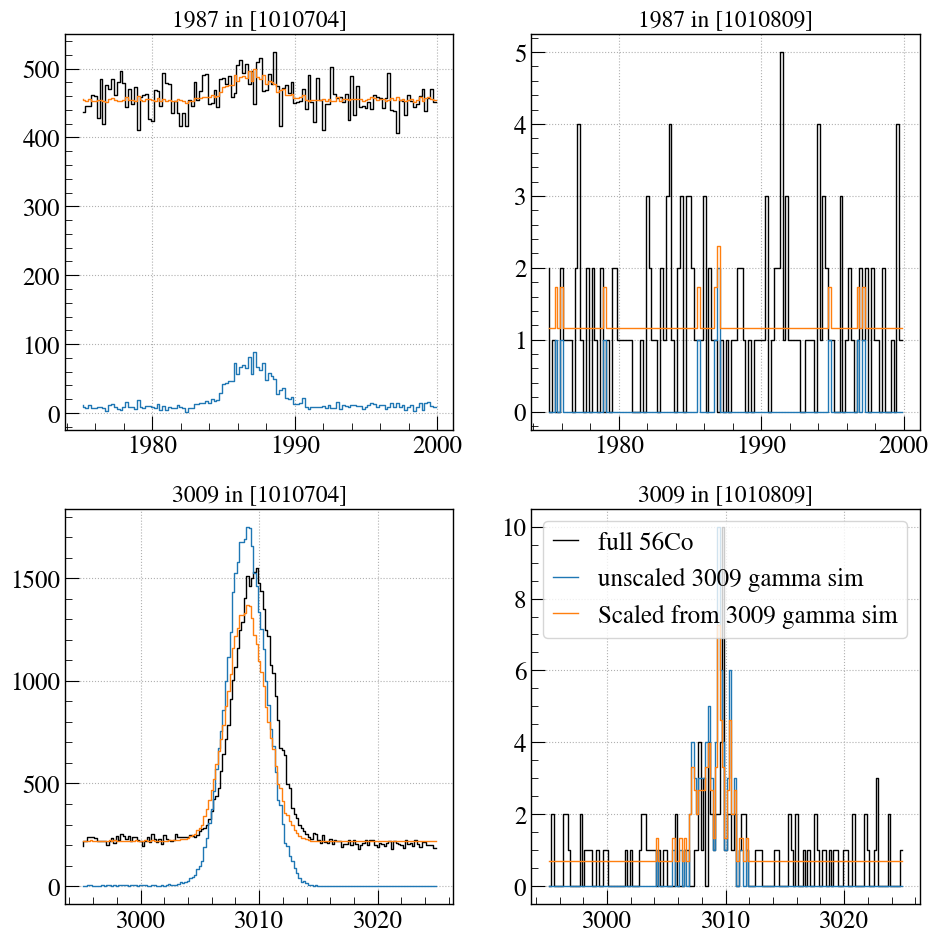

In [110]:


def compare_one_gamma_sim(df_full_Co, primaries_full_Co, df_one_gamma, peak, dets_to_use, axis=None):
    bkg_per_keV_per_primary_full_Co = get_bkg_per_keV_per_primary(df_full_Co, primaries_full_Co, dets_to_use, peak)
    print('bkg_per_keV_per_primary_full_Co', bkg_per_keV_per_primary_full_Co)

    d = df_vanc[df_vanc['mage_id'].isin(dets_to_use)]
    h, b, v = pgh.get_hist(d['energy'], range=(peak['sidebands'][0][0], peak['sidebands'][1][1]), dx=0.2)
    b_mids = (b[1:] + b[:-1])/2
    axis.plot(b_mids, h, ds='steps', c='k', lw=1, label='full 56Co')
    # fit_params = lu.fit_peak_binned_extra_basic(b_mids, h, axis=plt.gca(), lw=1)

    d = df_one_gamma[df_one_gamma['mage_id'].isin(dets_to_use)]
    h, b, v = pgh.get_hist(d['energy'], range=(peak['sidebands'][0][0], peak['sidebands'][1][1]), dx=0.2)
    b_mids = (b[1:] + b[:-1])/2
    axis.plot(b_mids, h, ds='steps', c='tab:blue', lw=1, label='unscaled 3009 gamma sim')
    scaled_Co_primaries = get_scaled_Co_primaries(primaries_full_Co, df_full_Co['energy'], df_one_gamma['energy'], peak, axis=None)
    left_bkg = np.sum(h[0:np.argmax(b_mids>peak['sidebands'][0][1])])
    # print('left_bkg', left_bkg)
    total_bkg = left_bkg*(b[-1]-b[0])/(peak['sidebands'][0][1]-peak['sidebands'][0][0])
    # print('total_bkg', total_bkg)
    h = h-total_bkg/len(h)
    h = h*primaries_full_Co/scaled_Co_primaries

    new_bkg = bkg_per_keV_per_primary_full_Co*primaries_vanc*(b[-1]-b[0])
    h = h+new_bkg/len(h)
    axis.plot(b_mids, h, ds='steps', c='tab:orange', lw=1, label='Scaled from 3009 gamma sim')

    plt.legend()
    # plt.ylim(400,500)


fig, ax = plt.subplots(2,2, figsize=(10,10))


peak = dep_peaks['1987']
dets_to_use = [1010704]
compare_one_gamma_sim(df_vanc, primaries_vanc, df, peak, dets_to_use, axis=ax[0,0])
ax[0,0].set_title('1987 in '+str(dets_to_use))
dets_to_use = [1010809]
compare_one_gamma_sim(df_vanc, primaries_vanc, df, peak, dets_to_use, axis=ax[0,1])
ax[0,1].set_title('1987 in '+str(dets_to_use))

peak = fep_peaks['3009']
dets_to_use = [1010704]
compare_one_gamma_sim(df_vanc, primaries_vanc, df, peak, dets_to_use, axis=ax[1,0])
ax[1,0].set_title('3009 in '+str(dets_to_use))
dets_to_use = [1010809]
compare_one_gamma_sim(df_vanc, primaries_vanc, df, peak, dets_to_use, axis=ax[1,1])
ax[1,1].set_title('3009 in '+str(dets_to_use))


10417
(26977.644493003565, 33135.355506996435, 1104.5118502332145)
37664
(799.8178460773386, 56800.18215392266, 2272.0072861569065)
peak_count_vanc 26977.644493003565


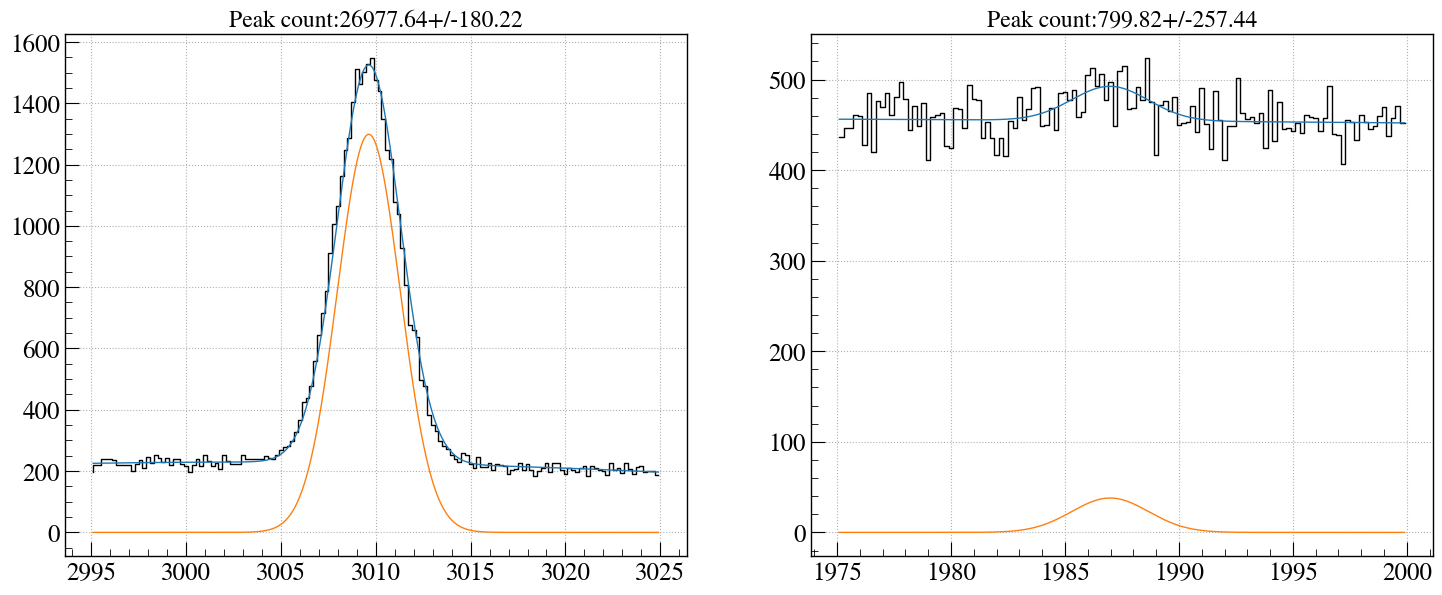

In [50]:
peak = dep_peaks['1987']
peak = fep_peaks['3009']
fig, ax = plt.subplots(1,2, figsize=(16,6))
bkg_per_kev_vancouver = 0 # bkg/keV
for i,peak in enumerate([fep_peaks['3009'], dep_peaks['1987']]):
    d = df_vanc[df_vanc['mage_id'].isin(dets_to_use)]
    hv, bv, vv = pgh.get_hist(d['energy'], range=(peak['sidebands'][0][0], peak['sidebands'][1][1]), dx=0.2)
    bv_mids = (bv[1:] + bv[:-1])/2
    ax[i].plot(bv_mids, hv, ds='steps', lw=1, color='k')
    # get sum of hv where 1960<bv<1975

    left_bkg = np.sum(hv[np.where((bv>peak['sidebands'][0][0]) & (bv<peak['sidebands'][0][1]))])
    right_bkg = np.sum(hv[np.where((bv>peak['sidebands'][1][0]) & (bv<peak['sidebands'][1][1]))])
    bkg_vanc = left_bkg + right_bkg
    print(bkg_vanc)
    print(get_peak_and_bkg_count(hv, bv))

    fit_results = lu.fit_peak_binned_extra_basic(bv_mids, hv, axis=ax[i], lw=1)
    ax[i].set_title('Peak count:'+ str(round(fit_results['area'],2))+'+/-'+str(round(fit_results['area_err'],2)))

    if i==0:
        peak_count_3009_vanc = fit_results['area']
print('peak_count_vanc', peak_count_3009_vanc)

In [ ]:
evt_filenames = '/global/homes/f/fnafis/LEGEND/legend/sims/evt_filenames_3009_sis2_neg376mm.txt'
df = pd.DataFrame()
primaries = 0
with open(evt_filenames) as f:
    evt_filenames = f.read().splitlines()
    for evt_filename in evt_filenames:
        print(evt_filename)
        ff = ur.open(evt_filename)
        # print(evt_filename, 'opened')
        dets = ff['simTree/mage_id'].array(library='np')
        primaries += len(dets)
        dets = np.concatenate(dets)
        
        energies = ff['simTree/energy'].array(library='np')
        energies = np.concatenate(energies)
        d = pd.DataFrame({'mage_id': dets, 'energy': energies})
        df = pd.concat([df, d], ignore_index=True)
   
print(primaries)
df['energy'] = df['energy'].apply(lambda x: x*1000)
df

/global/cfs/cdirs/m2676/users/nfuad/gamma_3009_sim/sis2_neg376_21183026_evt.root


ValueError: need at least one array to concatenate

New one FEP sim

(2463.9250726643963, 76.07492733560366)
8
(82.14499051274512, 192.85500948725488)
114
peak_count_new 2463.9250726643963


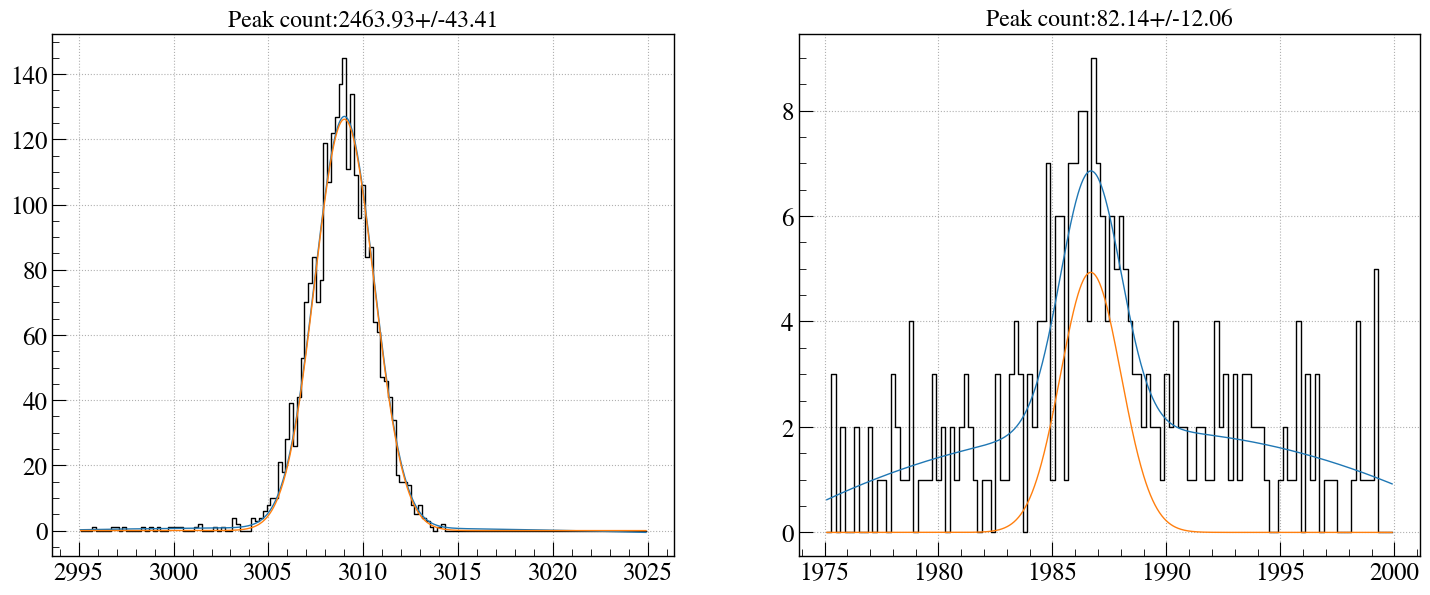

In [48]:
peak = dep_peaks['1987']
peak = fep_peaks['3009']
fig, ax = plt.subplots(1,2, figsize=(16,6))
for i,peak in enumerate([fep_peaks['3009'], dep_peaks['1987']]):
    d = df[df['mage_id'].isin(dets_to_use)]
    h, b, v = pgh.get_hist(d['energy'], range=(peak['sidebands'][0][0], peak['sidebands'][1][1]), dx=0.2)
    b_mids = (b[1:] + b[:-1])/2
    ax[i].plot(b_mids, h, ds='steps', lw=1, color='k')
    # get sum of hv where 1960<bv<1975
    print(get_peak_and_bkg_count(h, b))
    left_bkg = np.sum(h[np.where((b>peak['sidebands'][0][0]) & (b<peak['sidebands'][0][1]))])
    right_bkg = np.sum(h[np.where((b>peak['sidebands'][1][0]) & (b<peak['sidebands'][1][1]))])
    bkg_new = left_bkg + right_bkg
    print(bkg_new)

    
    fit_results = lu.fit_peak_binned_extra_basic(b_mids, h, axis=ax[i], lw=1)
    ax[i].set_title('Peak count:'+ str(round(fit_results['area'],2))+'+/-'+str(round(fit_results['area_err'],2)))

    if i==0:
        peak_count_3009_new = fit_results['area']
print('peak_count_new', peak_count_3009_new)

In [116]:
dets_to_use

[1010809]

Text(0.5, 1.0, '3009 gamma sim [1010704]')

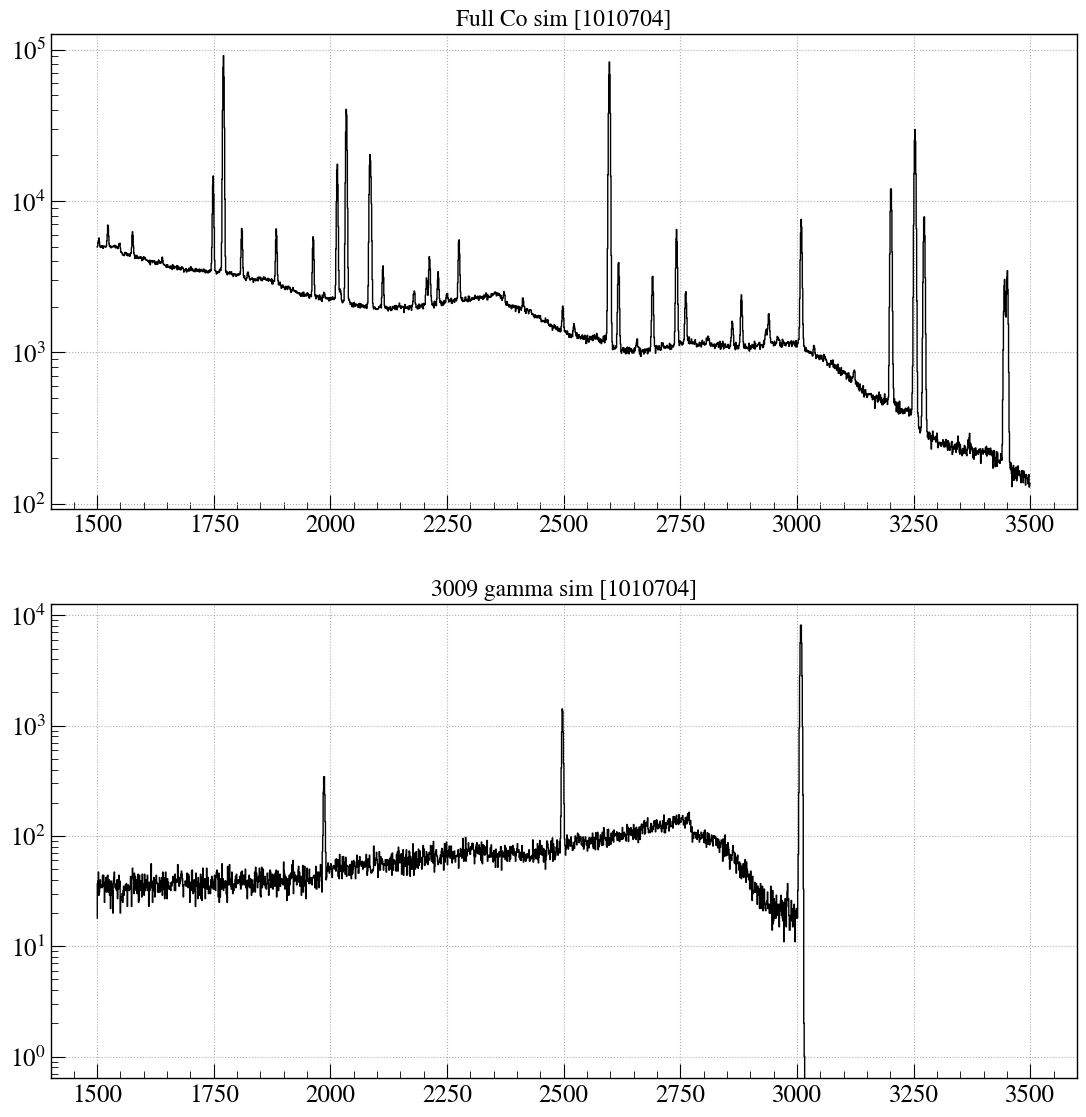

In [119]:
dets_to_use = [1010704]
h,b,v = pgh.get_hist(df_vanc['energy'][df_vanc['mage_id'].isin(dets_to_use)], range=(1500, 3500), dx=1)
b_mids = (b[1:] + b[:-1])/2
fig, ax = plt.subplots(2,1, figsize=(12,12))
ax[0].plot(b_mids, h, ds='steps', lw=1, color='k')
ax[0].set_yscale('log')
ax[0].set_title('Full Co sim '+str(dets_to_use))

h,b,v = pgh.get_hist(df['energy'][df['mage_id'].isin(dets_to_use)], range=(1500, 3500), dx=1)
b_mids = (b[1:] + b[:-1])/2
ax[1].plot(b_mids, h, ds='steps', lw=1, color='k')
ax[1].set_yscale('log')
ax[1].set_title('3009 gamma sim '+str(dets_to_use))

In [51]:
peak = dep_peaks['1987']

d_vanc = df_vanc[df_vanc['mage_id'].isin(dets_to_use)]
h, b, v = pgh.get_hist(d['energy'], range=(peak['sidebands'][0][0], peak['sidebands'][1][1]), dx=0.2)
peak_count_1987_vanc, bkg_1987_vanc, _ = get_peak_and_bkg_count(h, b)
print('peak_count_1987_vanc', peak_count_1987_vanc, 'bkg_1987_vanc', bkg_1987_vanc)
d = df[df['mage_id'].isin(dets_to_use)]
h, b, v = pgh.get_hist(d['energy'], range=(peak['sidebands'][0][0], peak['sidebands'][1][1]), dx=0.2)
peak_count_1987_new, bkg_1987_new, _ = get_peak_and_bkg_count(h, b)
print('peak_count_1987_new', peak_count_1987_new, 'bkg_1987_new', bkg_1987_new)

old_to_new_1987_peak_count_ratio = peak_count_1987_new/peak_count_1987_vanc


peak_count_1987_vanc 799.8178460773386 bkg_1987_vanc 56800.18215392266
peak_count_1987_new 82.14499051274512 bkg_1987_new 192.85500948725488


In [ ]:
def get_scaled_spectrum(df_full_Co, primaries_full_Co, df_one_gamma, primaries_one_gamma, peak, dets_to_use):
    bkg_per_keV_per_primary_full_Co = get_bkg_per_keV_per_primary(df_full_Co, primaries_full_Co, dets_to_use, peak)
    d = df_one_gamma[df_one_gamma['mage_id'].isin(dets_to_use)]
    h, b, v = pgh.get_hist(d['energy'], range=(peak['sidebands'][0][0], peak['sidebands'][1][1]), dx=0.2)

old_to_new_factor 8.479679807481908
primaries_new 1017561576.8978289
peak_count 799.8178460773386
B_sideband 37664.0
N_sideband 18527.0
tau 0.47058823529411764
rel_unc 0.06806230655345366
unc_vanc 0.06806230655345366
peak_count 30.34149410238941
B_sideband 373.1059115292039
N_sideband 381.58559133668587
tau 0.47058823529411764
rel_unc 0.03486229167467353
unc_new 0.03486229167467353


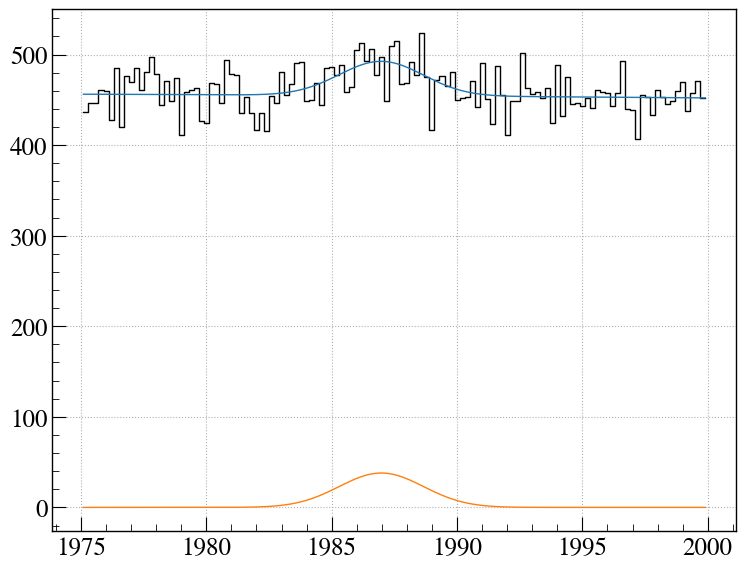

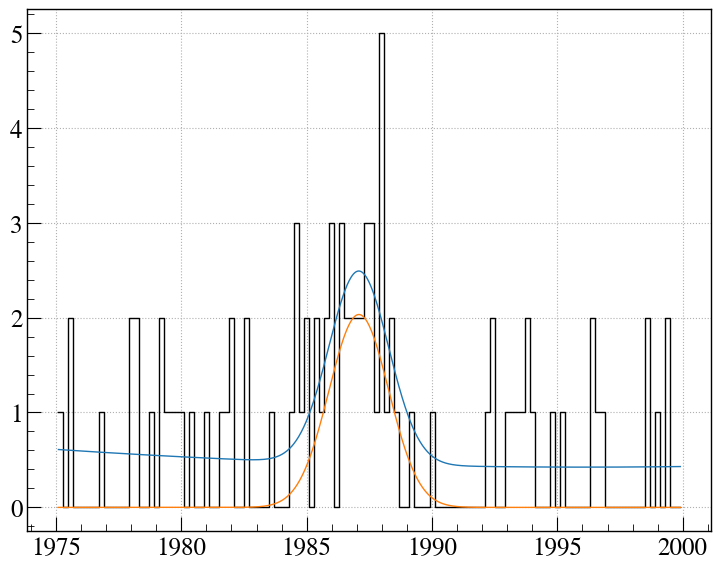

In [12]:
peak = dep_peaks['1987']
primaries_vanc = 120e6
old_to_new_factor = peak_count_3009_new/peak_count_3009_vanc
print('old_to_new_factor', old_to_new_factor)
primaries_new = primaries_vanc*old_to_new_factor
print('primaries_new', primaries_new)


# sse survival probability
def get_survival_probability_uncertainty(d, peak, old_to_new_factor):
    h, b, v = pgh.get_hist(d['energy'], range=(peak['sidebands'][0][0], peak['sidebands'][1][1]), dx=0.2)
    b_mids = (b[1:] + b[:-1])/2

    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(b_mids, h, ds='steps', lw=1, color='k')
    fit_results = lu.fit_peak_binned_extra_basic(b_mids, h, axis=ax, lw=1)
    peak_count = fit_results['area']
    print('peak_count', peak_count)

    # total events in d between end of first sideband and start of second sideband
    left_bkg = np.sum(h[np.where((b>peak['sidebands'][0][0]) & (b<peak['sidebands'][0][1]))])
    right_bkg = np.sum(h[np.where((b>peak['sidebands'][1][0]) & (b<peak['sidebands'][1][1]))])
    B = left_bkg + right_bkg
    B = B*old_to_new_factor
    print('B_sideband', B)
    N = np.sum(h[np.where((b>peak['sidebands'][0][1]) & (b<peak['sidebands'][1][0]))])
    N = N*old_to_new_factor
    print('N_sideband', N)
    tau = (peak['sidebands'][1][0]-peak['sidebands'][0][1])/(peak['sidebands'][1][1]-peak['sidebands'][1][0]+peak['sidebands'][0][1]-peak['sidebands'][0][0])
    print('tau',tau)
    epsilon = 0.9
    N_c = N*epsilon
    B_c = B*epsilon
    rel_unc_sqrd = (N+tau**2*B)/(N-tau*B)**2 + (N_c+tau**2*B_c)/(N_c-tau*B_c)**2 - 2*(N_c+tau**2*B_c)/(N_c-tau*B_c)/(N-tau*B)
    rel_unc = np.sqrt(rel_unc_sqrd)
    print('rel_unc', rel_unc)
    return rel_unc


d = df_vanc[df_vanc['mage_id'].isin(dets_to_use)]
unc_vanc = get_survival_probability_uncertainty(d, dep_peaks['1987'], old_to_new_factor=1.0)
print('unc_vanc', unc_vanc)
d = df[df['mage_id'].isin(dets_to_use)]
unc_new = get_survival_probability_uncertainty(d, dep_peaks['1987'], old_to_new_factor=old_to_new_factor)
print('unc_new', unc_new)


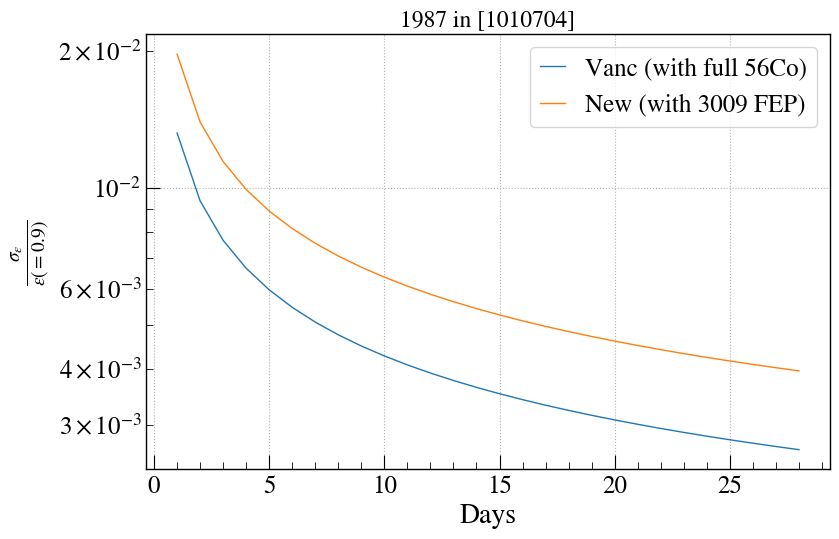

In [14]:
def get_unc_over_time(primaries, unc, **kwargs):
    source_activity_uCi = 1 #uCi
    source_activity_Bq = source_activity_uCi*3.7e4 #Bq

    half_life = 77.236 # days
    half_life = half_life*24*60*60 # seconds
    decay_constant = np.log(2)/half_life # 1/s

    days_elapsed = np.arange(1, 29, 1)
    uncs = []
    for d in days_elapsed:
        N = source_activity_Bq/decay_constant*(1-np.exp(-decay_constant*d*86400))
        uncertainty = unc*np.sqrt(primaries/N)
        uncs.append(uncertainty)

    plt.plot(days_elapsed, uncs, lw=1, **kwargs)

    plt.yscale('log')
    # plt.xscale('log')
    plt.xlabel('Days')
    plt.ylabel(r'$\frac{\sigma_{\epsilon}}{\epsilon(=0.9)}$')
    plt.title('1987 in '+str(dets_to_use))

get_unc_over_time(primaries_vanc, unc_vanc, label='Vanc (with full 56Co)')
get_unc_over_time(primaries_new, unc_new, label='New (with 3009 FEP)')
plt.legend()